### An example of a sparse hierarchical gaussian process

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import gpflow
from gpflow.config import default_jitter

from shgp import SHGP

SEED = 30
rng = np.random.RandomState(SEED)
tfp_seed = tfp.random.sanitize_seed(SEED)

2022-07-04 11:28:14.008153: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-04 11:28:14.008180: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-04 11:28:16.408461: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-04 11:28:16.408488: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-04 11:28:16.408506: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ma-res-amosm1): /proc/driver/nvidia/version does not exist


## Data generation

**REVISIT**

There are 4 functions $f_1, f_2, f_3, f_4$ that share some common function $g$ in addition to their own individual function $h_1, h_2, h_3, h_4$, such that $f_{i} = h_i + g$.

We generate this hierarchical data using Gaussian processes.

In [2]:
n_data = 100
n_realisations = 4
noise_limits = (0.3, 0.5)
xlims = (-5, 5)

In [3]:
X = np.linspace(*xlims, n_data).reshape(-1, 1)

true_kernel = gpflow.kernels.Matern32()
Kxx = true_kernel(X) + tf.cast(tf.eye(n_data)*default_jitter(), dtype=tf.float64)
group_y = tfp.distributions.MultivariateNormalTriL(np.zeros(n_data), tf.linalg.cholesky(Kxx)).sample(seed=tfp_seed)

noise_terms = np.random.uniform(*noise_limits, size=n_realisations)

def add_sig(i):
    X = np.linspace(*xlims, n_data).reshape(-1, 1)
    true_kernel = gpflow.kernels.Matern32()
    Kxx = true_kernel(X) + tf.cast(tf.eye(n_data)*default_jitter(), dtype=tf.float64)
    group_y = tfp.distributions.MultivariateNormalTriL(np.zeros(n_data), tf.linalg.cholesky(Kxx)).sample(seed=tfp_seed + 10 * i)
    sample_y = group_y.numpy()
    return sample_y

realisations = []
individual_ys = []
for i, noise in enumerate(noise_terms):
    sample_y = group_y.numpy() + rng.normal(loc=0., scale=noise, size=group_y.numpy().shape)
    individual_y = add_sig(i)
    sample_y += individual_y
    realisations.append(sample_y)
    individual_ys.append(individual_y)
Y = np.asarray(realisations).T

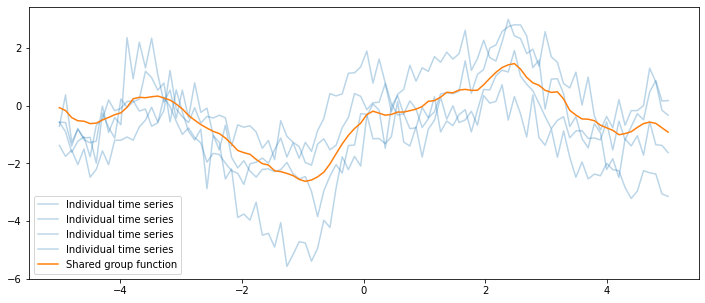

In [4]:
plt.figure(figsize=(12, 5))
[plt.plot(X, r, alpha=0.3, color='tab:blue', label='Individual time series') for r in realisations]
plt.plot(X, group_y, color='tab:orange', label='Shared group function')
plt.legend()
plt.show()


## The Sparse HGP

### Initialising

We specify the data, the initial locations for the inducing points and the group and indivudal kernels. In this example we use Matern32 kernels for both levels of the hierarchy (group and indivudal). 

Note that the individual kernels do not share hyperparameters, they are unique to each kernel. You can see that in the model summary below.

In [5]:
data = (X, Y)

n_inducing = 25
Z = np.linspace(*xlims, n_inducing).reshape(-1,1)
kernel = gpflow.kernels.Matern32()

shgp = SHGP(
    (X, Y),
    inducing_points=Z,
    group_kernel=kernel,
    individual_kernel=kernel
    )

In [6]:
shgp

name,class,transform,prior,trainable,shape,dtype,value
SHGP.inducing_points.Z,Parameter,Identity,,True,"(25, 1)",float64,[[-5....
SHGP.K_group.variance,Parameter,Softplus,,True,(),float64,1.0
SHGP.K_group.lengthscales,Parameter,Softplus,,True,(),float64,1.0
SHGP.K_individual_list[0].variance,Parameter,Softplus,,True,(),float64,1.0
SHGP.K_individual_list[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SHGP.K_individual_list[1].variance,Parameter,Softplus,,True,(),float64,1.0
SHGP.K_individual_list[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SHGP.K_individual_list[2].variance,Parameter,Softplus,,True,(),float64,1.0
SHGP.K_individual_list[2].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SHGP.K_individual_list[3].variance,Parameter,Softplus,,True,(),float64,1.0


### Fitting

We create a dictionary of fitting parameters (learning rate, number of optimisations steps etc) and fit the SHGP using Adam.

The compilation can take a while, but speeds up fitting by an order of magnitude.

In [7]:
params = dict()
params['optim_nits'] = 300
params['log_interval']= 20
params['learning_rate'] = 0.05

shgp.fit(params, compile=True)

100%|██████████| 300/300 [00:26<00:00, 11.44it/s, loss=617]   


We can check convergence of the ELBO

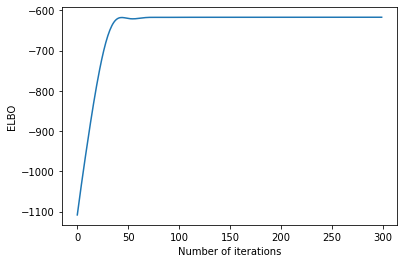

In [8]:
plt.plot(-np.asarray(shgp.objective_evals))
plt.ylabel('ELBO')
plt.xlabel('Number of iterations')
plt.show()

## Plotting the predictions

Because the hierarchical framework is linear we can plot both the combined *group* + *individual* predictions and the *group* function seperately.

Looking at the time series for the 4 variables

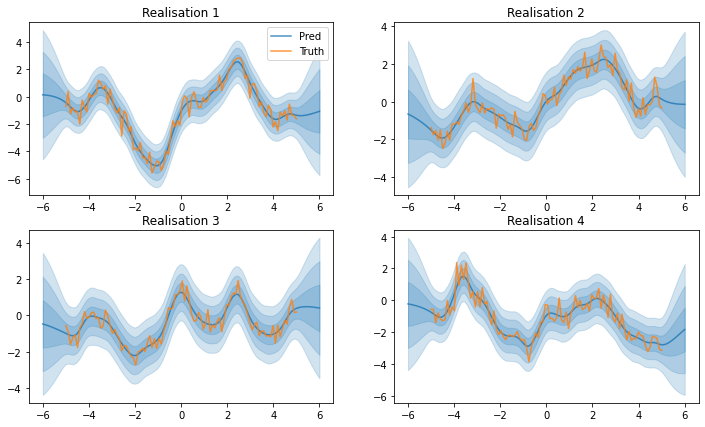

In [9]:
xte = np.linspace(-6, 6, n_data).reshape(-1, 1)
indi_preds = [shgp.predict_individual(xte, idx) for idx in range(n_realisations)]

plt.figure(figsize=(12,7))
for i, indi_pred in enumerate(indi_preds):
    indi_mean, indi_var = indi_pred
    indi_mean = indi_mean.numpy().squeeze()
    indi_std = np.sqrt(indi_var.numpy().squeeze())
    x = X.squeeze()
    xte=xte.squeeze()
    plt.subplot(2, 2, i + 1)
    plt.title(f'Realisation {i+1}')
    for j in range(1,4):
        plt.fill_between(xte, indi_mean - j * indi_std, indi_mean + j * indi_std, alpha=0.2, color='tab:blue')
    plt.plot(xte, indi_mean, label='Pred', color='tab:blue', alpha=0.8)
    plt.plot(x, Y[:, i], label='Truth', color='tab:orange', alpha=0.8)
    if i == 0:
        plt.legend()

plt.show()

The *group* prediction - What functionality is shared for all the individuals?

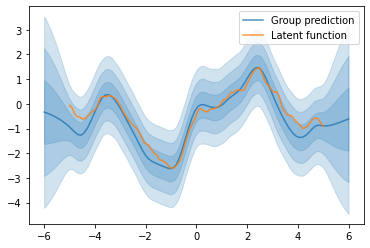

In [10]:
xte = np.linspace(-6, 6, n_data).reshape(-1, 1)
group_mean, group_var = shgp.predict_group(xte)
group_mean = group_mean.numpy().squeeze()
group_std = np.sqrt(group_var.numpy().squeeze())
for j in range(1,4):
    plt.fill_between(xte.squeeze(), group_mean - j * group_std, group_mean + j * group_std, alpha=0.2, color='tab:blue')
plt.plot(xte.squeeze(), group_mean, label='Group prediction', color='tab:blue', alpha=0.8)
plt.plot(x, group_y, label='Latent function', color='tab:orange', alpha=0.8)
plt.legend()
plt.show()